In [ ]:
from enum import Enum

from fastai.vision import *
from fastai.callbacks import TrainingPhase, GeneralScheduler

In [ ]:
print(f'fastai version: {__version__}')

fastai version: 1.0.59


In [ ]:
torch.cuda.set_device(2)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #2


Custom schedulers

In [ ]:
class AnnealType(Enum):
    NONE = 1
    LINEAR = 2
    COSINE = 3
    
# annealing functions = annealing_cos, annealing_exp, annealing_linear, annealing_no, annealing_poly
annealing_func_lookup = {
    AnnealType.NONE: annealing_no,
    AnnealType.LINEAR: annealing_linear,
    AnnealType.COSINE: annealing_cos
}

SGD with warm restarts ([from the fast.ai docs](https://docs.fast.ai/callbacks.general_sched.html))

In [ ]:
def fit_sgd_warm(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, anneal=annealing_cos)
                 .schedule_hp('mom', mom)) for i in range(n_cycles)]
    
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
        
    learn.fit(total_epochs)

[WarmupConstantSchedule](https://huggingface.co/pytorch-transformers/main_classes/optimizer_schedules.html#pytorch_transformers.WarmupConstantSchedule)

Linear warmup and then constant. Linearly increases learning rate schedule from 0 to 1 over warmup_steps training steps. Keeps learning rate schedule equal to 1. after warmup_steps.

[WarmupLinearSchedule](https://huggingface.co/pytorch-transformers/main_classes/optimizer_schedules.html#pytorch_transformers.WarmupLinearSchedule)

Linear warmup and then linear decay. Linearly increases learning rate from 0 to 1 over warmup_steps training steps. Linearly decreases learning rate from 1. to 0. over remaining t_total - warmup_steps steps.

[WarmupCosineSchedule](https://huggingface.co/pytorch-transformers/main_classes/optimizer_schedules.html#pytorch_transformers.WarmupCosineSchedule)

Linear warmup and then cosine decay. Linearly increases learning rate from 0 to 1 over warmup_steps training steps. Decreases learning rate from 1. to 0. over remaining t_total - warmup_steps steps following a cosine curve. If cycles (default=0.5) is different from default, learning rate follows cosine function after warmup.

In [ ]:
def fit_warmup(learn, n_cycles, warmup_steps=0.1, anneal_type:AnnealType=AnnealType.NONE,
                        lr=1e-3, betas=(0.9, 0.999), eps=1e-6, wd=0.0,
                        cycle_len=1, cycle_mult=1):
    # of total epochs
    if cycle_mult != 1:
        n_total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: 
        n_total_epochs = n_cycles * cycle_len
        
    # number steps per epoch and total steps
    n_epoch_steps = len(learn.data.train_dl)
    n_total_steps = n_epoch_steps * n_total_epochs
    
    # number of warmup steps
    n_warmup_steps = warmup_steps if type(warmup_steps) == int else int(n_total_steps * warmup_steps)
    
    phases = [
        (TrainingPhase(n_warmup_steps)
            .schedule_hp('lr', (0, lr), anneal=annealing_linear)
            .schedule_hp('mom', betas[0], anneal=None)
            .schedule_hp('beta', betas[1], anneal=None)
            .schedule_hp('eps', eps, anneal=None)
            .schedule_hp('wd', wd, anneal=None)),
        (TrainingPhase(n_total_steps - n_warmup_steps)
            .schedule_hp('lr', lr, anneal=annealing_func_lookup[anneal_type])
            .schedule_hp('mom', betas[0], anneal=None)
            .schedule_hp('beta', betas[1], anneal=None)
            .schedule_hp('eps', eps, anneal=None)
            .schedule_hp('wd', wd, anneal=None))
    ]
    
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    
    learn.fit(n_total_epochs)

[WarmupCosineWithHardRestartsSchedule](https://huggingface.co/pytorch-transformers/main_classes/optimizer_schedules.html#pytorch_transformers.WarmupCosineWithHardRestartsSchedule)

Linear warmup and then cosine cycles with hard restarts. Linearly increases learning rate from 0 to 1 over warmup_steps training steps. If cycles (default=1.) is different from default, learning rate follows cycles times a cosine decaying learning rate (with hard restarts).

In [ ]:
def fit_warmup_cosine_hard_restarts(learn, n_cycles, warmup_steps=0.2, 
                                    lr=1e-3, betas=(0.9, 0.999), eps=1e-6, wd=0.0,
                                    cycle_len=1, cycle_mult=1):
    
    # number of steps per epoch
    n_epoch_steps = len(learn.data.train_dl)
    
    # of total epochs
    if cycle_mult != 1:
        n_total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: 
        n_total_epochs = n_cycles * cycle_len
    
    # number of total steps
    n_total_steps = n_epoch_steps * n_total_epochs
    
    n_warmup_steps = warmup_steps if type(warmup_steps) == int else int(n_total_steps * warmup_steps)
    n_warmup_steps -= n_warmup_steps % n_cycles # ensure same number of iterations per cycle

    phases = [
        (TrainingPhase(n_warmup_steps)
             .schedule_hp('lr', (0, lr), anneal=annealing_linear)
             .schedule_hp('mom', betas[0], anneal=None)
             .schedule_hp('beta', betas[1], anneal=None)
             .schedule_hp('eps', eps, anneal=None)
             .schedule_hp('wd', wd, anneal=None))
    ]
    
    phases += [
        (TrainingPhase((n_epoch_steps * (cycle_len * cycle_mult**i)) - (n_warmup_steps // n_cycles))
             .schedule_hp('lr', lr, anneal=annealing_cos)
             .schedule_hp('mom', betas[0], anneal=None)
             .schedule_hp('beta', betas[1], anneal=None)
             .schedule_hp('eps', eps, anneal=None)
             .schedule_hp('wd', wd, anneal=None))
        for i in range(n_cycles)
    ]
    
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    
    learn.fit(n_total_epochs)

In [ ]:
def fit_warmup_cosine_warm_restarts(learn, n_cycles, warmup_steps=0.2, 
                                    lr=1e-3, betas=(0.9, 0.999), eps=1e-6, wd=0.0,
                                    cycle_len=1, cycle_mult=1):
    
    # number of steps per epoch
    n_epoch_steps = len(learn.data.train_dl)
    
    # of total epochs
    if cycle_mult != 1:
        n_total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: 
        n_total_epochs = n_cycles * cycle_len
    
    # number of total steps
    n_total_steps = n_epoch_steps * n_total_epochs
    
    phases = []
    for i in range(n_cycles):
        n_cycle_steps = n_epoch_steps * (cycle_len * cycle_mult**i)
        n_warmup_steps = warmup_steps if type(warmup_steps) == int else int(n_cycle_steps * warmup_steps)
        
        phases.append(
            (TrainingPhase(n_warmup_steps)
                 .schedule_hp('lr', (0,lr), anneal=annealing_linear)
                 .schedule_hp('mom', betas[0], anneal=None)
                 .schedule_hp('beta', betas[1], anneal=None)
                 .schedule_hp('eps', eps, anneal=None)
                 .schedule_hp('wd', wd, anneal=None)))

        phases.append(
            (TrainingPhase(n_cycle_steps - n_warmup_steps)
                 .schedule_hp('lr', lr, anneal=annealing_cos)
                 .schedule_hp('mom', betas[0], anneal=None)
                 .schedule_hp('beta', betas[1], anneal=None)
                 .schedule_hp('eps', eps, anneal=None)
                 .schedule_hp('wd', wd, anneal=None)))
        
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    
    learn.fit(n_total_epochs)

Tests

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

**SGD w/ warm restarts**

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Total training steps: {len(learn.data.train_dl)}')

fit_sgd_warm(learn, 3, 1e-3, 0.9, 1, 2)

Total training steps: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.189471,0.158700,0.947007,00:01
1,0.137863,0.133446,0.953876,00:01
2,0.136382,0.128314,0.954858,00:01
3,0.115644,0.110742,0.961236,00:01
4,0.102981,0.104913,0.964671,00:01
5,0.093083,0.091610,0.966634,00:01
6,0.092945,0.090742,0.966634,00:01


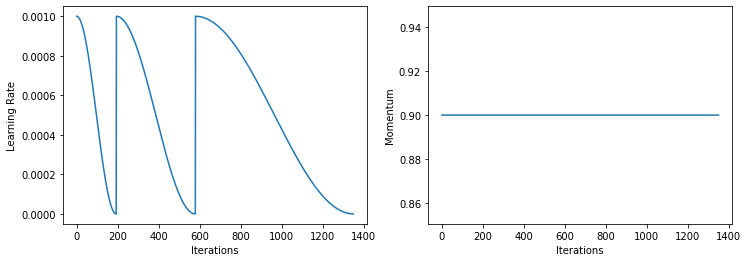

In [ ]:
learn.recorder.plot_lr(show_moms=True)

**WarmupConstantSchedule**

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Steps/epoch: {len(learn.data.train_dl)}')

fit_warmup(learn, 3, warmup_steps=.1, anneal_type=AnnealType.NONE, lr=1e-3, cycle_len=1, cycle_mult=2)

Steps/epoch: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.199383,0.130851,0.956330,00:01
1,0.120230,0.102103,0.963199,00:01
2,0.095082,0.084673,0.971541,00:01
3,0.076990,0.074277,0.975466,00:01
4,0.068841,0.072091,0.974485,00:01
5,0.072143,0.063615,0.975957,00:01
6,0.066172,0.060091,0.979882,00:01


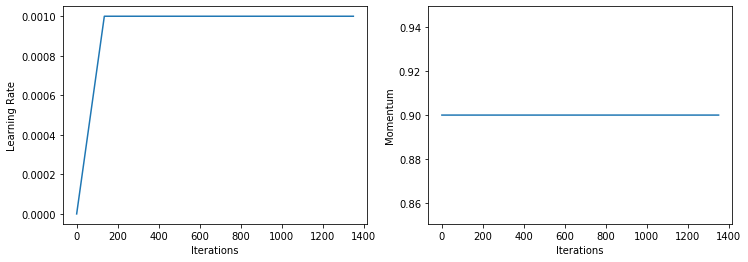

In [ ]:
learn.recorder.plot_lr(show_moms=True)

**WarmupLinearSchedule**

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Steps/epoch: {len(learn.data.train_dl)}')

fit_warmup(learn, 3, warmup_steps=.1, anneal_type=AnnealType.LINEAR, lr=1e-3, cycle_len=1, cycle_mult=2)

Steps/epoch: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.203069,0.129472,0.957802,00:01
1,0.118571,0.106033,0.961727,00:01
2,0.102296,0.100389,0.966143,00:01
3,0.091491,0.087518,0.968597,00:01
4,0.084474,0.085050,0.971050,00:01
5,0.080979,0.079759,0.971541,00:01
6,0.083386,0.079931,0.973013,00:01


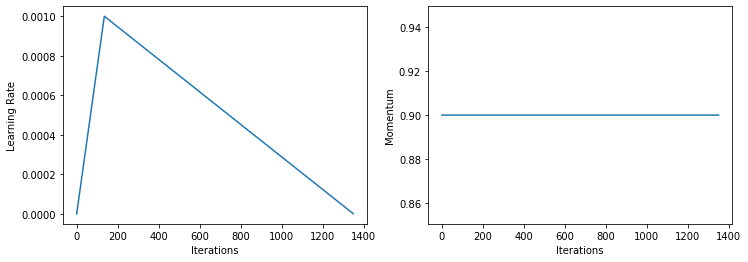

In [ ]:
learn.recorder.plot_lr(show_moms=True)

**WarmupCosineSchedule**

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Steps/epoch: {len(learn.data.train_dl)}')

fit_warmup(learn, 3, warmup_steps=.1, anneal_type=AnnealType.COSINE, lr=1e-3, cycle_len=1, cycle_mult=2)

Steps/epoch: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.220540,0.132794,0.948970,00:01
1,0.115143,0.101969,0.966143,00:01
2,0.090591,0.087163,0.968106,00:01
3,0.080638,0.078280,0.969087,00:01
4,0.081372,0.075143,0.974975,00:01
5,0.077743,0.072634,0.972522,00:01
6,0.072262,0.073451,0.975466,00:01


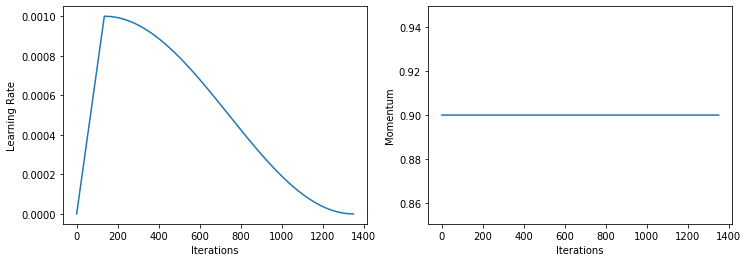

In [ ]:
learn.recorder.plot_lr(show_moms=True)

**WarmupCosineWithHardRestartsSchedule**

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Steps/epoch: {len(learn.data.train_dl)}')

fit_warmup_cosine_hard_restarts(learn, 3, warmup_steps=.1, lr=1e-3, cycle_len=1, cycle_mult=2)

Steps/epoch: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.212434,0.146703,0.947988,00:01
1,0.128138,0.128223,0.953876,00:01
2,0.119609,0.113982,0.960255,00:01
3,0.110937,0.106668,0.957802,00:01
4,0.099668,0.088248,0.968597,00:01
5,0.094338,0.082071,0.971050,00:01
6,0.091199,0.081432,0.971541,00:01


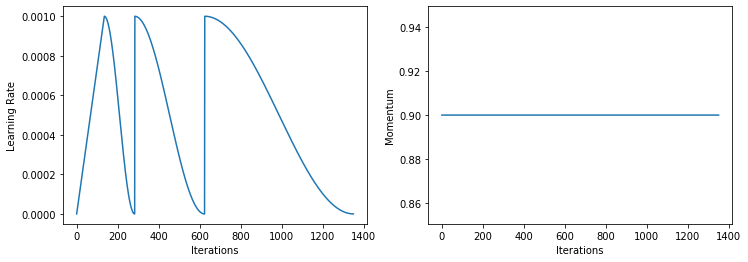

In [ ]:
learn.recorder.plot_lr(show_moms=True)

**WarmupCosineWithWarmRestartsSchedule**

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Steps/epoch: {len(learn.data.train_dl)}')

fit_warmup_cosine_warm_restarts(learn, 3, warmup_steps=.1, lr=1e-3, cycle_len=1, cycle_mult=2)

Steps/epoch: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.173858,0.163971,0.936703,00:01
1,0.133503,0.125587,0.955839,00:01
2,0.112885,0.116064,0.958292,00:01
3,0.100607,0.106966,0.964671,00:01
4,0.085772,0.082021,0.971050,00:01
5,0.079471,0.075159,0.973503,00:01
6,0.071563,0.073978,0.973994,00:01


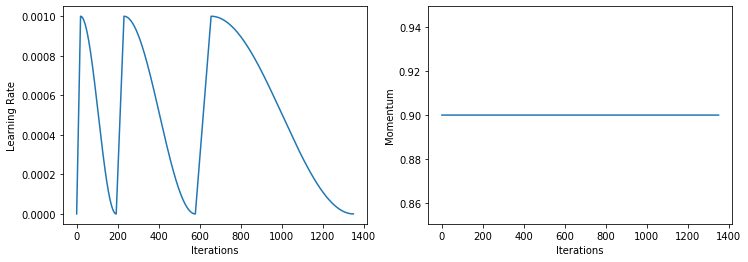

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
import pdb

In [ ]:
def lr_vaswani(start_lr, current_step, warmup_steps):
    pdb.set_trace()
    return start_lr * min(current_step**-0.5, current_step * warmup_steps**-1.5)

In [ ]:
def fit_test2(learn, n_cycles, warmup_steps=.1, anneal_type:AnnealType=AnnealType.NONE,
                        lr=1e-3, betas=(0.9, 0.999), eps=1e-9, wd=0.0,
                        cycle_len=1, cycle_mult=1):
    # of total epochs
    if cycle_mult != 1:
        n_total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: 
        n_total_epochs = n_cycles * cycle_len
        
    # number steps per epoch and total steps
    n_epoch_steps = len(learn.data.train_dl)
    n_total_steps = n_epoch_steps * n_total_epochs
    
    # number of warmup steps
    n_warmup_steps = warmup_steps if type(warmup_steps) == int else int(n_total_steps * warmup_steps)
    
    phases = [
        (TrainingPhase(n_warmup_steps)
            .schedule_hp('lr', (0, lr), anneal=annealing_linear)
            .schedule_hp('mom', betas[0], anneal=None)
            .schedule_hp('beta', betas[1], anneal=None)
            .schedule_hp('eps', eps, anneal=None)
            .schedule_hp('wd', wd, anneal=None)),
        (TrainingPhase(n_total_steps - n_warmup_steps)
            .schedule_hp('lr', lr, anneal=lr_vaswani)
            .schedule_hp('mom', betas[0], anneal=None)
            .schedule_hp('beta', betas[1], anneal=None)
            .schedule_hp('eps', eps, anneal=None)
            .schedule_hp('wd', wd, anneal=None))
    ]
    
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    
    learn.fit(n_total_epochs)

In [ ]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
print(f'Steps/epoch: {len(learn.data.train_dl)}')

fit_test2(learn, 3, warmup_steps=200, lr=2e-3)

Steps/epoch: 193


epoch,train_loss,valid_loss,accuracy,time
0,0.201887,0.133979,0.952404,00:01


> <ipython-input-52-05eab23a5ec3>(3)lr_vaswani()
-> return start_lr * min(current_step**-0.5, current_step * warmup_steps**-1.5)
(Pdb) l
  1  	def lr_vaswani(start_lr, current_step, warmup_steps):
  2  	    pdb.set_trace()
  3  ->	    return start_lr * min(current_step**-0.5, current_step * warmup_steps**-1.5)
[EOF]
(Pdb) start_lr
0.002
(Pdb) current_step
0
(Pdb) warmup_steps
0.002638522427440633
(Pdb) q


BdbQuit: 

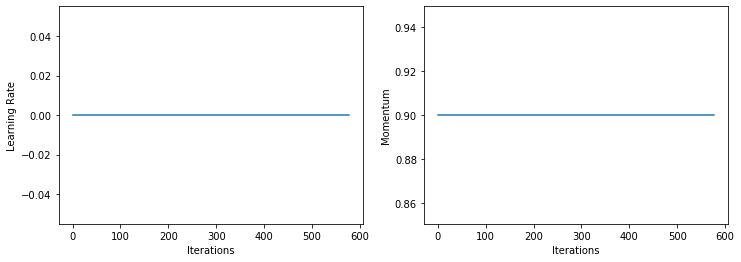

In [ ]:
learn.recorder.plot_lr(show_moms=True)